# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [6]:
import pandas as pd 
df = pd.read_csv("news_sample.csv")
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/katikistan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/katikistan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import re
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from cleantext import clean


def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
    # Flatten the list of tokens
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)
  return fq

In [9]:
dfcpy = df.copy()

dfcpy.content = dfcpy.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(dfcpy.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(dfcpy.tokenized)
# reduction rate of the vocabulary size
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)
vocab = build_vocabulary(dfcpy.tokenized)
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

After cleaning:
vocabulary size: 16577

After removing stopwords:
vocabulary size: 16445
reduction rate of the vocabulary size: 0.80%

After stemming:
vocabulary size: 11031
reduction rate of the vocabulary size: 32.92%




1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [10]:
#pip install "modin[ray]" (only works in python 3.10)
import modin.pandas as pd

In [11]:
df = pd.read_csv("995,000_rows.csv", usecols=['content', 'type', 'url', 'title', 'authors', 'domain'], engine='c', dtype = str, nrows=70000)
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])
dfcpy = dfcpy.dropna(subset=['type'])

2024-03-21 18:13:51,926	INFO worker.py:1724 -- Started a local Ray instance.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  # plot most be less than 2^16 pixels in each direction
  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [13]:
dfcpy.content = dfcpy.content.apply(clean_text)

In [14]:
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)


In [15]:
dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)

In [16]:
dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)

## Data exploration

In [17]:
vocab = build_vocabulary(dfcpy.tokenized)

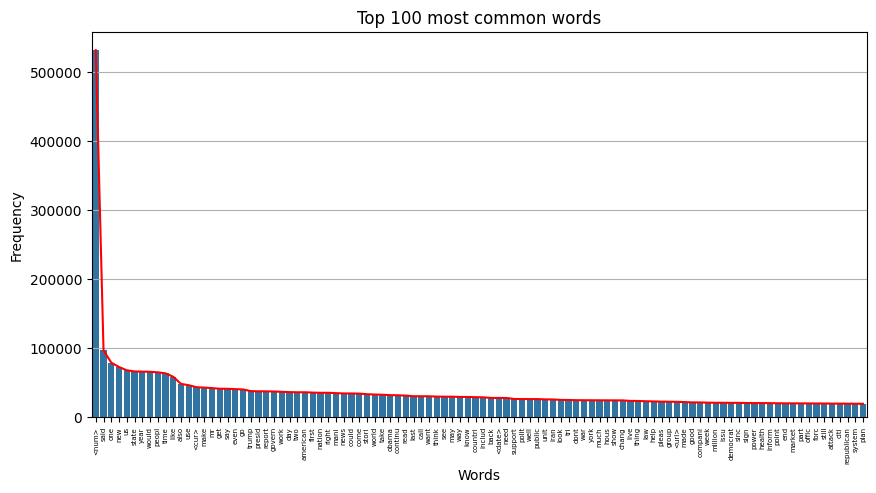

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


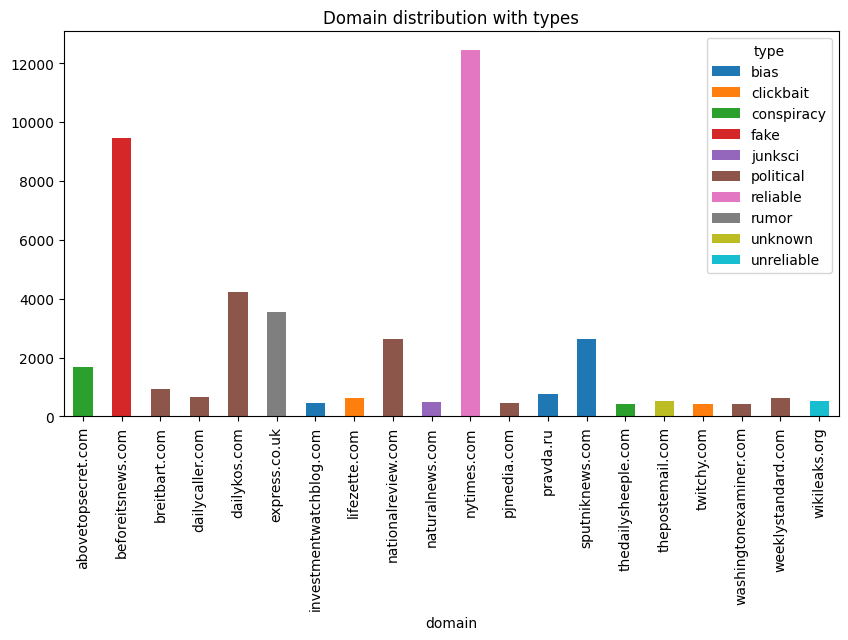

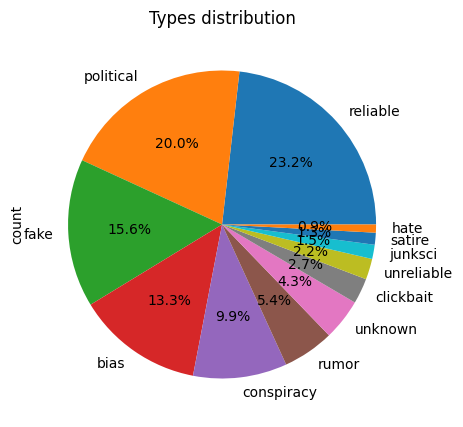

Number of dropped rows: 3504


In [18]:
def plot_domain_with_type(df):
  top_domains = df.domain.value_counts().head(20).index
  df = df[df.domain.isin(top_domains)]
  df = df.groupby(['domain', 'type']).size().unstack().fillna(0)

  df.plot(kind='bar', stacked=True, figsize=(10,5), title='Domain distribution with types')
  plt.show()
  return


num_freq = vocab.get("<num>",0)
plot_freq(vocab, 100)

# top 20 domains with their types
plot_domain_with_type(dfcpy)

# pie chart for the distribution of the types
dfcpy.type.value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,5), title='Types distribution')
plt.show()

# ammount of dropped rows
print(f"Number of dropped rows: {df.shape[0] - dfcpy.shape[0]}")

In [19]:
dfcpy.tokenized = dfcpy.tokenized.apply(lambda x: ' '.join(x))

# Task 4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('cleaned_news_sample.csv', usecols=['tokenized', 'type'], engine='c', dtype = str)
dfcpy = df.copy()


# label is 1 if the article is fake, 0 if the article is reliable
dfcpy['label'] = dfcpy['type'].map({'fake': 1, 'conspiracy': 1, 'junksci': 1, 'bias': 1, 'clickbait': 0, 'political': 0, 'reliable': 0})
dfcpy = dfcpy.dropna(subset=['label'])
dfcpy['label'] = dfcpy['label'].astype(int)

X = dfcpy['tokenized']
y = dfcpy['label']
X.dropna(inplace=True)
y = y.loc[X.index]


train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size= test_ratio / (test_ratio + validation_ratio), random_state = 42)

print("Training Set:")
print(x_train.head())
x_train = x_train.apply(lambda x: np.str_(x))
x_val = x_val.apply(lambda x: np.str_(x))
x_test = x_test.apply(lambda x: np.str_(x))

Training Set:
174    benzalkonium chlorid industri <num> global mar...
73     school choic often compar mani thing sen john ...
61     iraq oil industri current econom outlook reade...
134    studi cbd administr enhanc skelet heal reader ...
137    headlin bitcoin blockchain search exceed trump...
Name: tokenized, dtype: object


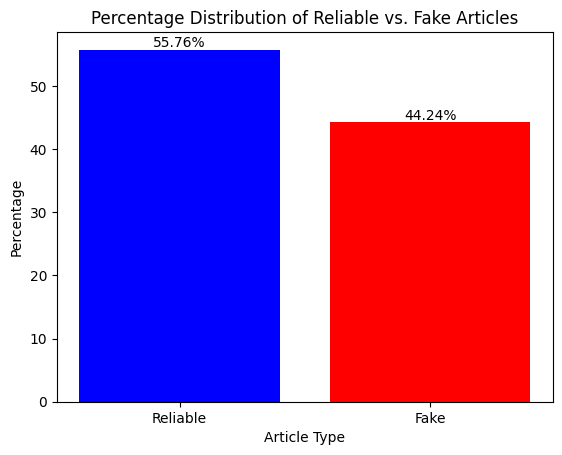

In [36]:
# Examine the percentage distribution of 'reliable' vs. 'fake' articles
grouped_type = dfcpy['label'].value_counts()
grouped_type = grouped_type / grouped_type.sum() * 100

# make a bar plot with percentages on bars
plt.bar([0, 1], grouped_type, tick_label=['Reliable', 'Fake'], color=['blue', 'red'])
plt.text(0, grouped_type[0], f'{grouped_type[0]:.2f}%', ha='center', va='bottom')
plt.text(1, grouped_type[1], f'{grouped_type[1]:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()

In [4]:
import sklearn.metrics as metrics
import seaborn as sns
def evaluate_model(y_val, y_pred):
    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

    # Classification report
    classification_report = metrics.classification_report(y_val, y_pred, target_names = ['fake', 'real'], zero_division=0)
    print(classification_report)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1 = metrics.f1_score(y_val, y_pred)
    print("f1 score:", f1)
    print("accuracy:", accuracy)

# Part 2: A simple model

/Users/esben/opt/anaconda3/envs/ex1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

        fake       0.00      0.00      0.00         1
        real       0.95      1.00      0.98        21

    accuracy                           0.95        22
   macro avg       0.48      0.50      0.49        22
weighted avg       0.91      0.95      0.93        22

f1 score: 0.9767441860465116
accuracy: 0.9545454545454546


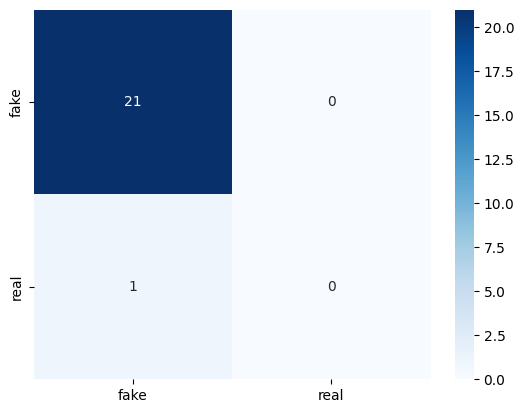

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# scaling the data
model = Pipeline([("tfidf", TfidfVectorizer()),
                ("scaler", StandardScaler(with_mean=False)), 
                ("log_reg", LogisticRegression(solver='sag', C=0.1))])
# prøv at sætte c lavere

model.fit(x_train, y_train)
y_pred = model.predict(x_val)
evaluate_model(y_val, y_pred)

# Part 3: Advanced model

3 models: 
- LinearSVM
- Naive bayes
- Random forrest

2 vector representations:
- TF-IDF, 3 grams
- Word embedding (word2vec)

We perfrom cross validation on hyper paramaters to find the best hyperparameters for each model 

## Vectorization

###  TF-IDF vectorizer

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(2, 2))),
    ('scaler', StandardScaler(with_mean=False)),
    # ('svd', TruncatedSVD(n_components=100))
    ])

X_train_TFIDF = pipeline.fit_transform(x_train, y_train) 
X_val_TFIDF = pipeline.transform(x_val)
X_test_TFIDF = pipeline.transform(x_test)


### Word2Vec

In [10]:
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer


w2v_model = Word2Vec(sentences=x_train, vector_size=100, window=5, min_count=1)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 100))
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

pipeline_w2v = Pipeline([
    ('tokenizer', Tokenizer()),
    ('vectorizer', get_weight_matrix(w2v_model, tokenizer.word_index))
])

X_train_W2V = pipeline_w2v.fit_transform(x_train)
X_val_W2V = pipeline_w2v.transform(x_val)
X_test_W2V = pipeline_w2v.transform(x_test)



AttributeError: This 'Pipeline' has no attribute 'fit_transform'

## Model 1: Linear SVC 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
def svc_advanced(x_train, y_train, x_val):
    svc = LinearSVC(dual=True)
    parameters = dict(C = [0.1 ,1, 10], loss = ['hinge', 'squared_hinge'], tol = [1e-3, 1, 10])

    # Cross-validation
    grid_search = GridSearchCV(svc, parameters, cv=2, n_jobs=19, scoring = 'f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    return grid_search.predict(x_val)

### TF-IDF 

Best Parameters: {'C': 100, 'loss': 'hinge', 'tol': 1}
              precision    recall  f1-score   support

        fake       0.85      0.90      0.87      3244
        real       0.88      0.81      0.84      2777

    accuracy                           0.86      6021
   macro avg       0.86      0.86      0.86      6021
weighted avg       0.86      0.86      0.86      6021

f1 score: 0.8416510318949343
accuracy: 0.8598239495100481


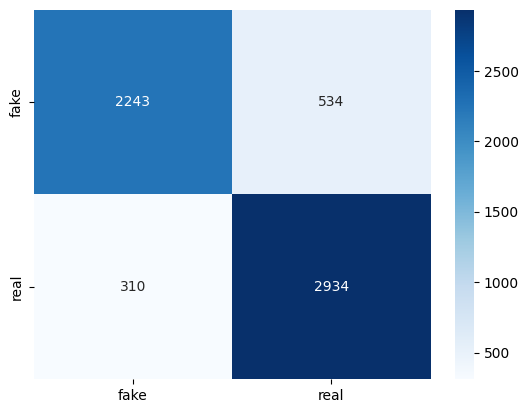

In [ ]:
y_pred = svc_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

### Word2vec

In [28]:
# y_pred = svc_advanced(X_train_W2V, y_train, X_val_W2V)
# evaluate_model(y_val, y_pred)

## Model 2: Naive bayes

Best Parameters: {'alpha': 1}
              precision    recall  f1-score   support

        fake       0.78      0.83      0.80      3244
        real       0.78      0.72      0.75      2777

    accuracy                           0.78      6021
   macro avg       0.78      0.78      0.78      6021
weighted avg       0.78      0.78      0.78      6021

f1 score: 0.751310861423221
accuracy: 0.7794386314565687


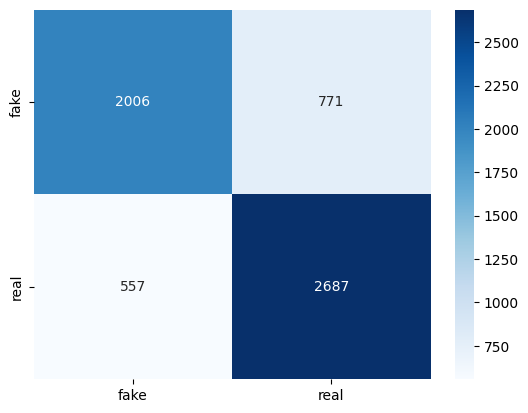

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

def naive_bayes_advanced(x_train, y_train, x_val):
    nb = MultinomialNB()
    parameters = dict(alpha = [0.01, 0.1, 1, 10, 100])

    # Cross-validation
    grid_search = GridSearchCV(nb, parameters, cv=2, n_jobs=19, scoring='f1')
    grid_search.fit(x_train, y_train)


    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    return grid_search.predict(x_val)

y_pred = naive_bayes_advanced(X_train_TFIDF, y_train, X_val_TFIDF)

### TF-IDF

Best Parameters: {'alpha': 1}
              precision    recall  f1-score   support

        fake       0.78      0.83      0.80      3244
        real       0.78      0.72      0.75      2777

    accuracy                           0.78      6021
   macro avg       0.78      0.78      0.78      6021
weighted avg       0.78      0.78      0.78      6021

f1 score: 0.751310861423221
accuracy: 0.7794386314565687


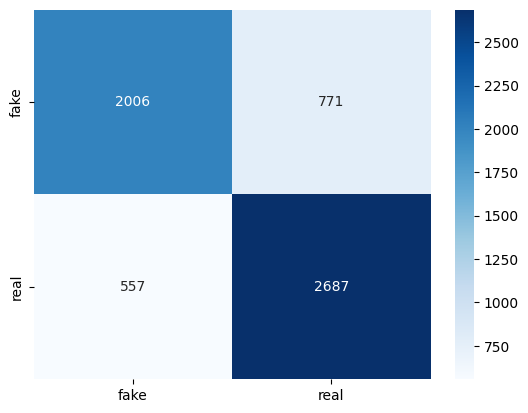

In [ ]:
y_pred = naive_bayes_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

### Word2Vec

In [31]:
# y_pred = naive_bayes_advanced(X_train_W2V, y_train, X_val_W2V)
# evaluate_model(y_val, y_pred)

## Model 3: Random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_advanced(x_train, y_train, x_val):
    rf = RandomForestClassifier()
    parameters = dict(n_estimators = [100, 200, 300], 
                      max_depth = [10, 20, 30])

    # Cross-validation
    grid_search = GridSearchCV(rf, parameters, cv=2, n_jobs=19, scoring='f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    return grid_search.predict(x_val)

In [33]:
# rf = RandomForestClassifier(random_state=42)

# pipeline_rf = Pipeline([
#     ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
#     ('rf', rf)
# ])


# param_grid = {
#     'rf__n_estimators': [100, 200, 300],  
#     'rf__max_depth': [10, 20, 30],  
# }

# # Cross-validation
# grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, n_jobs=-1, scoring='f1')
# grid_search.fit(x_train, y_train)

# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# y_pred = grid_search.predict(x_val)

### TF-IDF

In [ ]:
y_pred = random_forest_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
evaluate_model(y_val, y_pred)

### Word2Vec

In [ ]:
# y_pred = random_forest_advanced(X_train_W2V, y_train, X_val_W2V)
# evaluate_model(y_val, y_pred)
# use word embeddings on the training data
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer


w2v_model = Word2Vec(sentences=x_train, vector_size=100, window=5, min_count=1)

# Vocab size
vocab_size = len(w2v_model.wv.key_to_index)
print("Vocabulary size:", vocab_size)

#Present words as numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_numbers = tokenizer.texts_to_sequences(x_train)

#numerical replesentation of a few words
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break  


vocab_size = len(tokenizer.word_index) + 1

# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's int mapping
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, word_index)